<a href="https://colab.research.google.com/github/quantumRAV/16745_CourseProject/blob/main/PID_Google_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <img src="https://github.com/JuliaLang/julia-logo-graphics/raw/master/images/julia-logo-color.png" height="100" /> _Colab Notebook Template_

## Instructions
1. Work on a copy of this notebook: _File_ > _Save a copy in Drive_ (you will need a Google account). Alternatively, you can download the notebook using _File_ > _Download .ipynb_, then upload it to [Colab](https://colab.research.google.com/).
2. If you need a GPU: _Runtime_ > _Change runtime type_ > _Harware accelerator_ = _GPU_.
3. Execute the following cell (click on it and press Ctrl+Enter) to install Julia, IJulia and other packages (if needed, update `JULIA_VERSION` and the other parameters). This takes a couple of minutes.
4. Reload this page (press Ctrl+R, or ⌘+R, or the F5 key) and continue to the next section.

_Notes_:
* If your Colab Runtime gets reset (e.g., due to inactivity), repeat steps 2, 3 and 4.
* After installation, if you want to change the Julia version or activate/deactivate the GPU, you will need to reset the Runtime: _Runtime_ > _Factory reset runtime_ and repeat steps 3 and 4.

In [ ]:
%%shell
set -e

#---------------------------------------------------#
JULIA_VERSION="1.8.2" # any version ≥ 0.7.0
JULIA_PACKAGES="IJulia BenchmarkTools"
JULIA_PACKAGES_IF_GPU="CUDA" # or CuArrays for older Julia versions
JULIA_NUM_THREADS=2
#---------------------------------------------------#

if [ -z `which julia` ]; then
  # Install Julia
  JULIA_VER=`cut -d '.' -f -2 <<< "$JULIA_VERSION"`
  echo "Installing Julia $JULIA_VERSION on the current Colab Runtime..."
  BASE_URL="https://julialang-s3.julialang.org/bin/linux/x64"
  URL="$BASE_URL/$JULIA_VER/julia-$JULIA_VERSION-linux-x86_64.tar.gz"
  wget -nv $URL -O /tmp/julia.tar.gz # -nv means "not verbose"
  tar -x -f /tmp/julia.tar.gz -C /usr/local --strip-components 1
  rm /tmp/julia.tar.gz

  # Install Packages
  nvidia-smi -L &> /dev/null && export GPU=1 || export GPU=0
  if [ $GPU -eq 1 ]; then
    JULIA_PACKAGES="$JULIA_PACKAGES $JULIA_PACKAGES_IF_GPU"
  fi
  for PKG in `echo $JULIA_PACKAGES`; do
    echo "Installing Julia package $PKG..."
    julia -e 'using Pkg; pkg"add '$PKG'; precompile;"' &> /dev/null
  done

  # Install kernel and rename it to "julia"
  echo "Installing IJulia kernel..."
  julia -e 'using IJulia; IJulia.installkernel("julia", env=Dict(
      "JULIA_NUM_THREADS"=>"'"$JULIA_NUM_THREADS"'"))'
  KERNEL_DIR=`julia -e "using IJulia; print(IJulia.kerneldir())"`
  KERNEL_NAME=`ls -d "$KERNEL_DIR"/julia*`
  mv -f $KERNEL_NAME "$KERNEL_DIR"/julia

  echo ''
  echo "Successfully installed `julia -v`!"
  echo "Please reload this page (press Ctrl+R, ⌘+R, or the F5 key) then"
  echo "jump to the 'Checking the Installation' section."
fi

Installing Julia 1.8.2 on the current Colab Runtime...
2024-04-18 00:42:23 URL:https://storage.googleapis.com/julialang2/bin/linux/x64/1.8/julia-1.8.2-linux-x86_64.tar.gz [135859273/135859273] -> "/tmp/julia.tar.gz" [1]
Installing Julia package IJulia...


# Checking the Installation
The `versioninfo()` function should print your Julia version and some other info about the system:

In [ ]:
versioninfo()

Julia Version 1.8.2
Commit 36034abf260 (2022-09-29 15:21 UTC)
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 2 × Intel(R) Xeon(R) CPU @ 2.20GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-13.0.1 (ORCJIT, broadwell)
  Threads: 2 on 2 virtual cores
Environment:
  LD_LIBRARY_PATH = /usr/local/nvidia/lib:/usr/local/nvidia/lib64
  JULIA_NUM_THREADS = 2


In [ ]:
using BenchmarkTools

M = rand(2^11, 2^11)

@btime $M * $M;

  554.854 ms (2 allocations: 32.00 MiB)


In [ ]:
try
    using CUDA
catch
    println("No GPU found.")
else
    run(`nvidia-smi`)
    # Create a new random matrix directly on the GPU:
    M_on_gpu = CUDA.CURAND.rand(2^11, 2^11)
    @btime $M_on_gpu * $M_on_gpu; nothing
end

No GPU found.


# **PID Control**


In [9]:
import Pkg
Pkg.instantiate()
Pkg.add("Plots")
Pkg.add("LinearAlgebra")
Pkg.add("ForwardDiff")
Pkg.add("JLD2")
Pkg.add("Test")
Pkg.add("Random")
Pkg.add("XLSX")
Pkg.add("DataFrames")
Pkg.add("PlotlyJS")
Pkg.add("PlotlyBase")
using LinearAlgebra, Plots
import ForwardDiff as FD
using JLD2
using Test
using Random
using XLSX
using DataFrames

   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Chan

For Testing and Debug:

In [2]:

C = [
    5.989   -0.9064   0.03291  -0.02712   -0.1507  -0.04718    0.0933;
    0.8791   0.07148    -1.444   0.04786  0.009275    0.1406  -0.06804;
    2.715     2.921    0.1039  -0.02854    0.1448   -0.1276  -0.09767
] # C matrix, C = [no, ns] -> maps states to outputs

x0 = rand(7)
y0 = C*x0
@show x0

x0_est = pinv(C)*y0
@show x0_est

t_start = 0 #seconds
t_end = 200 #seconds
t_step = 1/16
t = t_start:t_step:t_end
P_jaw = 0.050 #psi
f_init = 0.05 #Hz
f_final = 2 #Hz

f_t = (f_final - f_init)./(t_end - t_start).*t .+ f_init
P_target = P_jaw.*sin.(2 .*pi .*f_t .*t)

plot(t, P_target,label="Pressure time trajectory", xlabel="t(s)", ylabel="pressure (psi)", legend=:topleft)

df = DataFrame(XLSX.readtable("/content/Modified_Data.xlsx","Sheet1"))

x0 = [0.9205254945156136, 0.4602163812228045, 0.1678154282686083, 0.6271035750804054, 0.2452351204330555, 0.9857879240712891, 0.3747598133324448]
x0_est = [0.905314524271517, 0.4266218619603318, 0.053602429040278204, -0.008067586238858539, 0.012848573921789896, -0.02865548404397284, -0.007884946711586516]


Row,INFO,Datalog_time,time_delta_s,object_class,object_size,program_mode,x_mm,y_mm,z_mm,P_closure_psi,P_jaw1_psi,P_jaw2_psi,P_jaw3_psi,commanded_closure_pressure_psi,commanded_P_jaw1_psi,commanded_P_jaw2_psi,commanded_P_jaw3_psi,commanded_x_mm,commanded_y_mm,commanded_z_mm,sequence_num,corrected_time_s
,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any,Any
1,INFO,2024:Apr:06_10:05:00,97.5619,rigid,40,KOOPMAN,-9.325,12.925,-180.18,-0.022887,0.006866,0.011443,0.025176,8.00634,0,0,0,-11.6487,15.0471,-180.18,0,0
2,INFO,2024:Apr:06_10:05:00,97.6148,rigid,40,KOOPMAN,-9.4375,13.025,-180.18,-0.022887,0.006866,0.011443,0.025176,8.00634,0,0,0,-11.6487,15.0471,-180.18,0,0.0529346
3,INFO,2024:Apr:06_10:05:00,97.6747,rigid,40,KOOPMAN,-10.8625,14.325,-180.18,6.63259,0.002289,0.004577,0.025176,8.00634,0,0,0,-11.6487,15.0471,-180.18,0,0.11278
4,INFO,2024:Apr:06_10:05:00,97.7419,rigid,40,KOOPMAN,-11.65,15.05,-180.18,8.09506,0.002289,0.004577,0.025176,8.00634,0,0,0,-11.6487,15.0471,-180.18,0,0.180036
5,INFO,2024:Apr:06_10:05:00,97.819,rigid,40,KOOPMAN,-11.65,15.05,-180.18,7.83415,0.006866,0.011443,0.025176,8.00634,0,0,0,-11.6487,15.0471,-180.18,0,0.257064
6,INFO,2024:Apr:06_10:05:00,97.8668,rigid,40,KOOPMAN,-11.65,15.05,-180.18,9.44309,0.002289,0.011443,0.025176,8.00634,0,0,0,-11.6487,15.0471,-180.18,0,0.30492
7,INFO,2024:Apr:06_10:05:00,97.9279,rigid,40,KOOPMAN,-11.65,15.05,-180.18,4.52701,0.002289,0.011443,0.025176,8.00634,0,0,0,-11.6487,15.0471,-180.18,0,0.366021
8,INFO,2024:Apr:06_10:05:00,97.9789,rigid,40,KOOPMAN,-11.65,15.05,-180.18,8.42463,0.002289,0.011443,0.025176,8.00634,0,0,0,-11.6487,15.0471,-180.18,0,0.416955
9,INFO,2024:Apr:06_10:05:00,98.0401,rigid,40,KOOPMAN,-11.65,15.05,-180.18,9.69484,0.002289,0.011443,0.025176,8.00634,0,0,0,-11.6487,15.0471,-180.18,0,0.478237


In [3]:
g=2
z=[2 3]
v=[g ; z[:]]
@show v
@show typeof(v)

v = [2, 2, 3]
typeof(v) = Vector{Int64}


Vector{Int64} (alias for Array{Int64, 1})

Read Experimental Data from xlsx file



In [4]:
# ----- read excel table of 1st experiment data ----- #
df = DataFrame(XLSX.readtable("/content/Modified_Data.xlsx","Sheet1"))
controls =  df[!,["commanded_closure_pressure_psi","commanded_x_mm"," commanded_y_mm"]];
states = df[!,["P_jaw1_psi","P_jaw2_psi","P_jaw3_psi"]];

controls_mat = Matrix{Float64}(controls)
states_mat = Matrix{Float64}(states)

@show typeof(controls_mat)
@show typeof(controls)
@show typeof(states)


typeof(controls_mat) = Matrix{Float64}
typeof(controls) = DataFrame
typeof(states) = DataFrame


DataFrame

Dynamics Simulation Functions



In [5]:
# Define parameters
mutable struct Params
    A::Matrix
    B::Matrix
    C::Matrix
    K::Float64
    Ki::Float64
    Kd::Float64
    prev_error::Vector
    target_position::Matrix
    nc::Int64
    ns::Int64
    no::Int64
    x0::Vector
    default_controls::Vector
end

# Koopman dynamics function, the equation, may need to add more
function koopman_dynamics(params::Params, z::Vector, u::Vector) #is u a vector? yes, up to the x y pressure data
    z_k_1 = params.A * z + params.B * u
    return z_k_1
end

# Mapping function from state x to lifted vector z (psi function)
function map_x_to_z(params::Params, x::Vector)
    return pinv(params.C)*x # In this example, let's assume identity mapping
end

# Mapping function from lifted vector z to state x (zeta function)
function map_z_to_x(params::Params, z::Vector)
    return params.C*z # In this example, let's assume identity mapping
end

# PID control function , make this time, x_t is not being used here???
function PID(params::Params, z::Vector, x_t::Vector)
    x = map_z_to_x(params, z)
    e = x[1] - x_t[1] #somewhat of a hack, only calculating the error based on the 1st observable, which is the commanded grasper pressure
    #v += e
    #v = min(v_max, max(v_min, v))
    u_k = params.K * e #+ params.Ki * v  #note: sum(e) is that based on time or all 3 jaws' error at certain time t?
   # params.prev_error = e # PI controlled
    return u_k
end

function simulation(params::Params, N::Int, x_0::Vector, u::AbstractArray )
    # N is the number of timesteps, y_0 is the initial condition in the observation space
    # u is the control matrix [nc, N-1]

    x_sim = zeros(params.no, N) #observables -> jaw pressures
    z_sim = zeros(params.ns, N) #"lifted" states
    @assert size(u,2) == (N-1)


    # Initial state
    x_sim[:, 1] .= x_0
    z_sim[:, 1] = map_x_to_z(params, x_sim[:, 1])

    for k in 1:(N-1)
        z_sim[:, k+1] = koopman_dynamics(params, z_sim[:, k], u[:,k])
        x_sim[:, k+1] = map_z_to_x(params, z_sim[:, k+1])
    end

    return x_sim
end


# Simulation function
function simulation_PID(params::Params, N::Int64)


    x_sim = zeros(params.no, N) #observables -> jaw pressures
    z_sim = zeros(params.ns, N) #"lifted" states -> don't really know what these mean
    u_sim = zeros(params.nc, N-1) #controls

    # Initial state
    x_sim[:, 1] = params.x0
    z_sim[:, 1] = map_x_to_z(params, x_sim[:, 1])

    for k in 1:(N-1)
        pressure_control = PID(params, z_sim[:, k], params.target_position[:,k])
        u_temp = [pressure_control; params.default_controls[2:3][:]]
        u_sim[:,k] = u_temp

        z_sim[:, k+1] = koopman_dynamics(params, z_sim[:, k], u_sim[:,k])
        x_sim[:, k+1] = map_z_to_x(params, z_sim[:, k+1])
    end

    return x_sim, u_sim
end

simulation_PID (generic function with 1 method)

Perform simulation with dynamics on the experimental data

In [6]:
nc = 3 #how many control inputs, x,y,pressure
ns = 7 #how many variable states -> based on SVD of time shifted matrix
no = 3 #how many observables we have -> 3, one for each jaw pressure

A = [
    0.9973    0.004034   0.0007657     0.02431     0.01357     0.01238   -0.006208;
   -0.003939       0.998    0.001406     0.01417    -0.03863     0.02738     0.02432;
    0.001417    -0.00222      0.9976   -0.003849   -0.001349      0.0283    0.005359;
  -0.0007166   -0.009299    0.001067      0.9213    -0.07444      -0.181    0.000149;
   -0.003075   0.0004973     0.00102    0.006896      0.6525      0.1616      0.5525;
   -0.007101    0.001852    0.003425     0.02647    -0.08303      0.6047      -0.303;
    0.002164    0.003805    0.002082     0.02341      -0.151    -0.07977      0.5948
]
  #  A matrix, try with identity matrix A = [ns, ns] -> maps states at time k to states at time k + 1.

B = [
    0.0002128   6.626e-05   0.0001326;
    4.397e-05  -0.0002775  -0.0001025;
   -0.0002039  -1.922e-05   4.814e-05;
    0.0001348  -0.0003862   -0.000892;
   -0.0007546   -0.001424   -0.001171;
     0.002649   -0.001188   -0.001323;
    0.0009935   -0.002304    -0.00106
]
       #  B matrix, B = [ns, nc] -> maps inputs to states


C = [
    5.989   -0.9064   0.03291  -0.02712   -0.1507  -0.04718    0.0933;
    0.8791   0.07148    -1.444   0.04786  0.009275    0.1406  -0.06804;
    2.715     2.921    0.1039  -0.02854    0.1448   -0.1276  -0.09767
] # C matrix, C = [no, ns] -> maps states to outputs


K = -1000                 #  Proportional gain, P
Ki = 0.1                #  Integral gain, I
Kd = 0.01               #  Derivative gain, D
#P_target_pressure = [1, 1, 1] #p_jaw1, p_jaw2, p_jaw3, matrix dim needs to be changed
#time VECTOR

# ----- setup trajectory to track ---- #
t_start = 0 #seconds
t_end = 1000 #seconds
t_step = 1/16
t = t_start:t_step:t_end
P_jaw = 0.050 #psi
P_offset = P_jaw + 0.01 #psi
f_init = 0.001 #Hz
f_final = 2 #Hz

f_t = (f_final - f_init)./(t_end - t_start).*t .+ f_init
P_target = P_jaw.*sin.(2 .*pi .*f_t .*t) .+ P_offset

N = size(t,1)

target_position = transpose(Matrix(hcat(P_target, x0[2]*ones(N),x0[3]*ones(N))))
@show size(target_position)
@show N

plot(t, P_target,label="Pressure time trajectory", xlabel="t(s)", ylabel="pressure (psi)", legend=:topleft)



x0 = states_mat[1,:]
@show x0
default_controls = controls_mat[1,:]
@show default_controls

params = Params(A, B, C, K, Ki, Kd, zeros(2), target_position,nc,ns,no,x0, default_controls)




size(target_position) = (3, 16001)
N = 16001
x0 = [0.006866, 0.011443, 0.025176]
default_controls = [8.006341, -11.64866679944717, 15.0470922660159]


Params([0.9973 0.004034 … 0.01238 -0.006208; -0.003939 0.998 … 0.02738 0.02432; … ; -0.007101 0.001852 … 0.6047 -0.303; 0.002164 0.003805 … -0.07977 0.5948], [0.0002128 6.626e-5 0.0001326; 4.397e-5 -0.0002775 -0.0001025; … ; 0.002649 -0.001188 -0.001323; 0.0009935 -0.002304 -0.00106], [5.989 -0.9064 … -0.04718 0.0933; 0.8791 0.07148 … 0.1406 -0.06804; 2.715 2.921 … -0.1276 -0.09767], -1000.0, 0.1, 0.01, [0.0, 0.0], [0.060000000000000005 0.0600220880954425 … 0.010000004878839806 0.059999999999844775; 0.4602163812228045 0.4602163812228045 … 0.4602163812228045 0.4602163812228045; 0.1678154282686083 0.1678154282686083 … 0.1678154282686083 0.1678154282686083], 3, 7, 3, [0.006866, 0.011443, 0.025176], [8.006341, -11.64866679944717, 15.0470922660159])

Simulate Dynamics from Experiment

In [7]:
# ----- Simulate the Forward Dynamics ---- #
x_0 = Vector(states_mat[1,:])

N_forward = size(states_mat,1)


u = transpose(controls_mat[1:N_forward-1,:])
xsim = simulation(params, N_forward, x_0, u  )

t_forward= (1:N_forward).*t_step

#plot the simulated vs expected pressures at the jaw using the linear model with Hankel delay embeddings:
p1 = plot(t_forward, xsim[1,:],label="Simulated Jaw Pressure 1", xlabel="t(s)", ylabel="pressure (psi)", legend=:topleft) #jaw 1
plot!(t_forward, states_mat[:,1],label="Actual Jaw Pressure 1", xlabel="t(s)", ylabel="pressure (psi)", legend=:topleft)

p2 = plot(t_forward, xsim[2,:],label="Simulated Jaw Pressure 2", xlabel="t(s)", ylabel="pressure (psi)", legend=:topleft) #jaw 2
plot!(t_forward, states_mat[:,2],label="Actual Jaw Pressure 2", xlabel="t(s)", ylabel="pressure (psi)", legend=:topleft)

p3 = plot(t_forward, xsim[3,:],label="Simulated Jaw Pressure 3", xlabel="t(s)", ylabel="pressure (psi)", legend=:topleft) #jaw 3
plot!(t_forward, states_mat[:,3],label="Actual Jaw Pressure 3", xlabel="t(s)", ylabel="pressure (psi)", legend=:topleft)


plot(p1, p2, p3, layout=(3,1))



PID Simulation



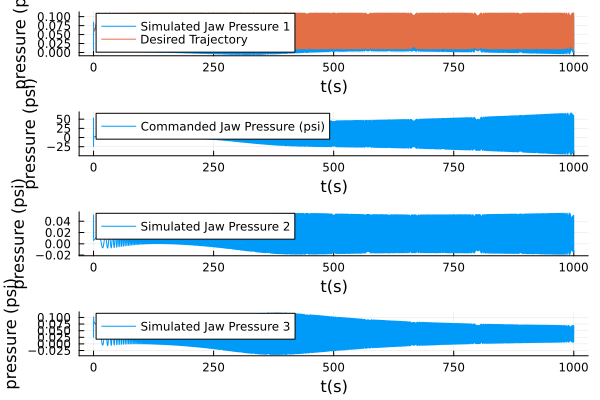

In [8]:
# ----- Run PID Simulation ---- #

# Run simulation
#fs= 16hz


x_sim, u_sim = simulation_PID(params, N)

# Plotting



p1 = plot(t, x_sim[1,:],label="Simulated Jaw Pressure 1", xlabel="t(s)", ylabel="pressure (psi)", legend=:topleft) #jaw 1
plot!(t, params.target_position[1,:],label="Desired Trajectory", xlabel="t(s)", ylabel="pressure (psi)", legend=:topleft)

p2 = plot(t[1:end-1], u_sim[1,:],label="Commanded Jaw Pressure (psi)", xlabel="t(s)", ylabel="pressure (psi)", legend=:topleft) #jaw 1


p3 = plot(t, x_sim[2,:],label="Simulated Jaw Pressure 2", xlabel="t(s)", ylabel="pressure (psi)", legend=:topleft) #jaw 2

p4 = plot(t, x_sim[3,:],label="Simulated Jaw Pressure 3", xlabel="t(s)", ylabel="pressure (psi)", legend=:topleft) #jaw 3

plot(p1, p2, p3, p4, layout=(4,1))

# Need Help?

* Learning: https://julialang.org/learning/
* Documentation: https://docs.julialang.org/
* Questions & Discussions:
  * https://discourse.julialang.org/
  * http://julialang.slack.com/
  * https://stackoverflow.com/questions/tagged/julia

If you ever ask for help or file an issue about Julia, you should generally provide the output of `versioninfo()`.

Add new code cells by clicking the `+ Code` button (or _Insert_ > _Code cell_).

Have fun!

<img src="https://raw.githubusercontent.com/JuliaLang/julia-logo-graphics/master/images/julia-logo-mask.png" height="100" />